# Home Credit Default Risk

## Introduction

    In this project, we aim to develop a machine learning model to predict the likelihood of a customer defaulting on a home credit loan. This is a classification problem where the target variable is binary, indicating whether the customer will default (1) or not (0).

    The notebook is organized into sections for better readability. However, please note that the actual workflow may vary at times, as my thoughts were somewhat scattered throughout the process.

## Install Packages

In [1]:
# ! pip install catboost
# ! pip install numpy
# ! pip install pandas
# ! pip install matplotlib
# ! pip install seaborn
# ! pip install scikit-learn

## Define Variables

In [2]:
# Define thresholds for Z-score (e.g., 3 and -3)
POSITVE_THRESHOLD = 3
NEGATIVE_THRESHOLD = -3

## Define Paths

In [3]:
# Application_train table path 
APPLICATION_TRAIN_DATA_PATH = '../data/interim/df_last.csv'

# Application_train table path 
BUREAU_DATA_PATH = '../data/raw/bureau.csv'

# Application_train table path 
PREVIOUS_APPLICATION_DATA_PATH = '../data/raw/previous_application.csv'

# Processed data directory
PROCESSED_DIR = '../data/processed'

# Model Directory
MODEL_DIR = '../models'

## Define Functions

In [4]:
def explore(x):
    """
    This function takes a dataframe as an input and
    return shape and info about the columns in the dataframe.

    Args:
    x (dataframe): The input dataframe to be explored.
    """
    print(x.info(), '\n\nShape:', x.shape)

In [5]:
def nulls_percentage(x):
    """ 
    This function returns the nulls total count for each column 
    and it's percentage

    Args:
        x (dataframe): The input dataframe to calculate nulls count for each column.

    Returns:
        dataframe: nulls count and percentage for each column in the input dataframe.

    Example:
    * nulls_percentage(df)
    
    .
    """
    y = x.isnull().sum().sort_values(ascending=False)
    y = y.to_frame(name='Missing_Values')
    y['Percentage %'] = y['Missing_Values']/x.shape[0]*100
    return y

In [6]:
def nulls_drop(data, x):
    """
    This function drops the columns with null values greater than x percentage.

    Args:
        data (dataframe): The input dataframe.
        x (float): The threshold value (the null percentage value in decimal of which you want to drop null percentages above).

    Returns:
        data (dataframe): Cleaned dataframe (after dropping columns having a null percentage above the desired threshold value).

    Example:
    * nulls_drop(df , 0.7)   ---> drop columns with nulls percentage above 70%.

    .
    """

    # calculate the threshold number of non-null values needed (x% of the column values)
    threshold = int((1-x) * data.shape[0])
    # drop columns above certain threshold
    data.dropna(axis=1, thresh=threshold, inplace= True)
    # show the cleaned dataframe
    return data

In [7]:
def repeat_percentage(data, x=''):
    """    
    This function determines the percentage of occurrence for each unique value within a specific column.

    Args:
        data (dataframe): The input dataframe.
        x (str): The specific column name you want to check repeated values in it. Defaults to ''.

    Returns:
        Pandas Series: Pandas series indicating the percentage of occurrence for each unique value within a specific column.

    Example:
    * repeat_percentage(df , 'NAME_CONTRACT_TYPE')

    .
    """
    return (data[x].value_counts()*100)/data.shape[0]

In [8]:
def correlation(data, x=[], y=''):
    """
    This function calculates the correlation between numerical variables (features) in a dataset.

    Args:
        data (dataframe): The input dataframe.
        x (list): The list of columns you want to measure the correlation between. Defaults to [].
        y (str): The target column in which you want to measure correlation within (must exist in the x list also). Defaults to ''.

    Returns:
        dataframe: A dataframe containing the percentage of correlation, indicating whether it is a negative or positive correlation. (from -1 to 1).
    
    Example:
    * correlation(df , [ 'EXT_SOURCE_3' , 'EXT_SOURCE_2' , 'EXT_SOURCE_1' , 'TARGET' ] , 'TARGET')

    .
    """
    return data.loc[:,x].corr().sort_values(by= y, axis=0, ascending=False)


In [9]:
def relation(data, x='', y=None):
  """ 
  This function evaluates the relation between a value or a class in a specific column with the different classes in the "TARGET" column for analysis purpose.
  

  Args:
      data (dataframe): The input dataframe.
      x (str): The desired column (feature). Defaults to ''.
      y (str, int or float): The desired value you want to evaluate with the target column whether it is a string, integer or a float. Defaults to None.

  Example:
   * relation(df, x='feature1', y=1)

   * relation(df_application_train, x='ORGANIZATION_TYPE', y='Postal')

  .
  """
  print('relation between ' , y , ' and TARGET\n' ,data[data[x] == y]["TARGET"].value_counts(normalize=True),'\n')

In [10]:
def corr_heatmap(data, threshold):
  """  
  This function takes your numerical dataframe as an input, and plot a correlation heatmap figure for analysis purposes.


  Args:
      data (dataframe): The input dataframe (must contain numerical features only).
      threshold (float): enter the threshold value and tune it as needed.

  Example:
      corr_heatmap(data= df, threshold= 0.5)

  
  .
  """
  # create correlation matrix with abs values
  corr_matrix = data.corr().abs()
  # filter the matrix due to threshold value
  filtered_corr_df = corr_matrix[(corr_matrix >= threshold) & (corr_matrix != 1.000)]

  plt.figure(figsize=(18,10))
  sns.heatmap(filtered_corr_df, annot=True, cmap="Reds")
  plt.show()

## Import Packages

In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [12]:
pd.set_option('display.max_columns', None)

## 1. Load Data

In [13]:
df_application_train = pd.read_csv(APPLICATION_TRAIN_DATA_PATH)

In [14]:
df_bureau = pd.read_csv(BUREAU_DATA_PATH)

In [15]:
df_previous_application = pd.read_csv(PREVIOUS_APPLICATION_DATA_PATH)

## 2. Explore Data 

### 2.1 General Exploration

    Explore the data using Python and Microsoft Excel to come out with insights about the data

In [16]:
df_application_train.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,YEARS_BIRTH,YEARS_EMPLOYED,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_2,EXT_SOURCE_3,LIVINGAREA_AVG,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_YEAR,YEARS_REGISTRATION,YEARS_ID_PUBLISH,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,25.920548,1.745205,NaN,1,0.262949,0.139376,0.0190,0.014900,2,2,2,2,1,9.994521,5.808219,2,2,0,0,0,Cash loans,M,N,Y,Unaccompanied,Working,Single / not married,House / apartment,Laborers,Business Entity Type 3
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,45.931507,3.254795,NaN,2,0.622246,0.380545,0.0549,0.071400,1,0,1,0,0,3.249315,0.797260,1,1,0,0,0,Cash loans,F,N,N,Family,State servant,Married,House / apartment,Core staff,School
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,52.180822,0.616438,26.0,1,0.555912,0.729567,0.0745,0.068559,0,0,0,0,0,11.671233,6.934247,2,2,0,0,0,Revolving loans,M,Y,Y,Unaccompanied,Working,Single / not married,House / apartment,Laborers,Government
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,52.068493,8.326027,NaN,2,0.650442,0.451486,0.0745,0.068800,2,0,2,0,1,26.939726,6.676712,2,2,0,0,0,Cash loans,F,N,Y,Unaccompanied,Working,Civil marriage,House / apartment,Laborers,Business Entity Type 3
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,54.608219,8.323288,NaN,1,0.322738,0.451486,0.0745,0.068800,0,0,0,0,0,11.810959,9.473973,2,2,0,0,0,Cash loans,M,N,Y,Unaccompanied,Working,Single / not married,House / apartment,Core staff,Religion


In [17]:
explore(df_application_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Data columns (total 38 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307507 non-null  int64  
 1   TARGET                       307507 non-null  int64  
 2   CNT_CHILDREN                 307507 non-null  int64  
 3   AMT_INCOME_TOTAL             307507 non-null  float64
 4   AMT_CREDIT                   307507 non-null  float64
 5   AMT_ANNUITY                  307507 non-null  float64
 6   AMT_GOODS_PRICE              307507 non-null  float64
 7   REGION_POPULATION_RELATIVE   307507 non-null  float64
 8   YEARS_BIRTH                  307507 non-null  float64
 9   YEARS_EMPLOYED               307507 non-null  float64
 10  OWN_CAR_AGE                  104585 non-null  float64
 11  CNT_FAM_MEMBERS              307507 non-null  int64  
 12  EXT_SOURCE_2                 307507 non-null  float64
 13 

In [18]:
df_application_train.select_dtypes('object').nunique()

NAME_CONTRACT_TYPE     2
CODE_GENDER            2
FLAG_OWN_CAR           2
FLAG_OWN_REALTY        2
NAME_TYPE_SUITE        7
NAME_INCOME_TYPE       8
NAME_FAMILY_STATUS     6
NAME_HOUSING_TYPE      6
OCCUPATION_TYPE       18
ORGANIZATION_TYPE     58
dtype: int64

In [19]:
df_application_train['REGION_RATING_CLIENT_W_CITY'].value_counts()

REGION_RATING_CLIENT_W_CITY
2    229481
3     43859
1     34167
Name: count, dtype: int64

In [20]:
df_application_train['FLAG_OWN_CAR'].value_counts()

FLAG_OWN_CAR
N    202922
Y    104585
Name: count, dtype: int64

In [21]:
df_application_train['FLAG_OWN_REALTY'].value_counts()

FLAG_OWN_REALTY
Y    213308
N     94199
Name: count, dtype: int64

In [22]:
df_application_train['ORGANIZATION_TYPE'].value_counts()

ORGANIZATION_TYPE
Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11192
Business Entity Type 2    10553
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6879
Construction               6721
Business Entity Type 1     5983
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3277
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7      

### 2.2 Verify Repeated Values

    Check repeated values percentages

In [23]:
repeat_percentage(df_application_train, 'NAME_CONTRACT_TYPE')

NAME_CONTRACT_TYPE
Cash loans         90.479892
Revolving loans     9.520108
Name: count, dtype: float64

In [24]:
repeat_percentage(df_application_train, 'REG_REGION_NOT_LIVE_REGION')

REG_REGION_NOT_LIVE_REGION
0    98.485563
1     1.514437
Name: count, dtype: float64

In [25]:
repeat_percentage(df_application_train, 'REG_REGION_NOT_WORK_REGION')

REG_REGION_NOT_WORK_REGION
0    94.923042
1     5.076958
Name: count, dtype: float64

In [26]:
repeat_percentage(df_application_train, 'NAME_HOUSING_TYPE')

NAME_HOUSING_TYPE
House / apartment      88.734565
With parents            4.825906
Municipal apartment     3.636340
Rented apartment        1.587281
Office apartment        0.851038
Co-op apartment         0.364870
Name: count, dtype: float64

In [27]:
repeat_percentage(df_application_train, 'NAME_INCOME_TYPE')

NAME_INCOME_TYPE
Working                 51.631670
Commercial associate    23.289226
Pensioner               18.003493
State servant            7.057726
Unemployed               0.007154
Student                  0.005854
Businessman              0.003252
Maternity leave          0.001626
Name: count, dtype: float64

In [28]:
repeat_percentage(df_application_train, 'OCCUPATION_TYPE')

OCCUPATION_TYPE
Laborers                 17.946258
Sales staff              10.439437
Core staff                8.965324
Managers                  6.949760
Drivers                   6.049618
High skill tech staff     3.700729
Accountants               3.191147
Medicine staff            2.776197
Security staff            2.185641
Cooking staff             1.933615
Cleaning staff            1.513136
Private service staff     0.862419
Low-skill Laborers        0.680310
Waiters/barmen staff      0.438364
Secretaries               0.424381
Realty agents             0.244222
HR staff                  0.183085
IT staff                  0.171053
Name: count, dtype: float64

In [29]:
repeat_percentage(df_application_train,'NAME_TYPE_SUITE')

NAME_TYPE_SUITE
Unaccompanied      81.238801
Family             13.055963
Spouse, partner     3.697477
Children            1.062415
Other_B             0.575597
Other_A             0.281620
Group of people     0.088128
Name: count, dtype: float64

In [30]:
repeat_percentage(df_application_train, 'DEF_60_CNT_SOCIAL_CIRCLE')

DEF_60_CNT_SOCIAL_CIRCLE
0     91.620679
1      7.102277
2      1.030871
3      0.194467
4      0.043576
5      0.006504
6      0.000976
7      0.000325
24     0.000325
Name: count, dtype: float64

### 2.3 Analyze the Skewness

    Analyze the Skewness to assess whether the data follows a normal distribution or not

In [31]:
numerical_columns = df_application_train.select_dtypes(['int64','float64'])
categorical_columns = df_application_train.select_dtypes('object')

In [32]:
numerical_columns.skew()

SK_ID_CURR                      -0.001213
TARGET                           3.078133
CNT_CHILDREN                     1.974634
AMT_INCOME_TOTAL               391.557413
AMT_CREDIT                       1.234761
AMT_ANNUITY                      1.579809
AMT_GOODS_PRICE                  1.350141
REGION_POPULATION_RELATIVE       1.488033
YEARS_BIRTH                      0.115667
YEARS_EMPLOYED                   2.212855
OWN_CAR_AGE                      2.745481
CNT_FAM_MEMBERS                  0.987559
EXT_SOURCE_2                    -0.795936
EXT_SOURCE_3                    -0.186780
LIVINGAREA_AVG                  10.963572
TOTALAREA_MODE                  11.182271
OBS_30_CNT_SOCIAL_CIRCLE        12.144696
DEF_30_CNT_SOCIAL_CIRCLE         5.192502
OBS_60_CNT_SOCIAL_CIRCLE        12.076064
DEF_60_CNT_SOCIAL_CIRCLE         5.286464
AMT_REQ_CREDIT_BUREAU_YEAR       1.465677
YEARS_REGISTRATION               0.590872
YEARS_ID_PUBLISH                -0.349330
REGION_RATING_CLIENT             0

### 2.4 Histograms

    Create a histogram for features that are highly skewed in order to identify potential outliers in the data

array([[<Axes: title={'center': 'OWN_CAR_AGE'}>]], dtype=object)

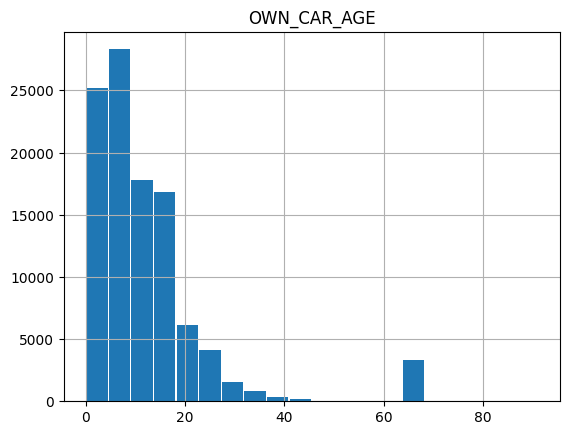

In [33]:
pd.DataFrame.hist(df_application_train, column='OWN_CAR_AGE', bins= 20, rwidth=0.95)

array([[<Axes: title={'center': 'CNT_CHILDREN'}>]], dtype=object)

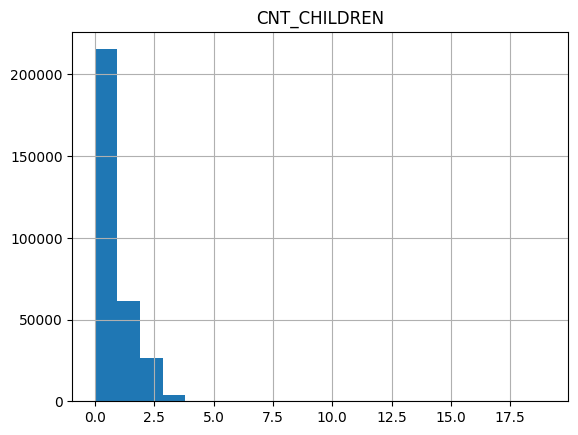

In [34]:
pd.DataFrame.hist(df_application_train, column='CNT_CHILDREN', bins= 20)

array([[<Axes: title={'center': 'DEF_60_CNT_SOCIAL_CIRCLE'}>]],
      dtype=object)

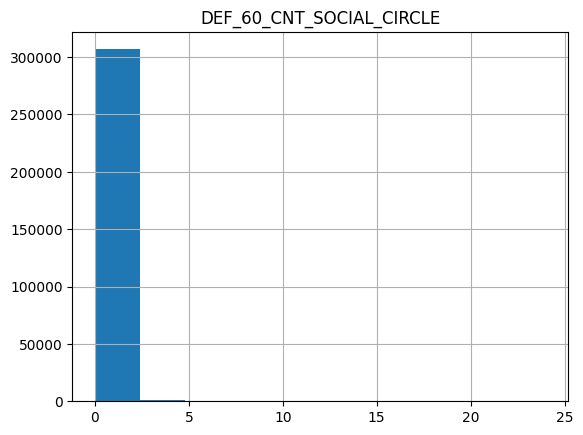

In [35]:
pd.DataFrame.hist(df_application_train, 'DEF_60_CNT_SOCIAL_CIRCLE', bins=10)

array([[<Axes: title={'center': 'YEARS_EMPLOYED'}>]], dtype=object)

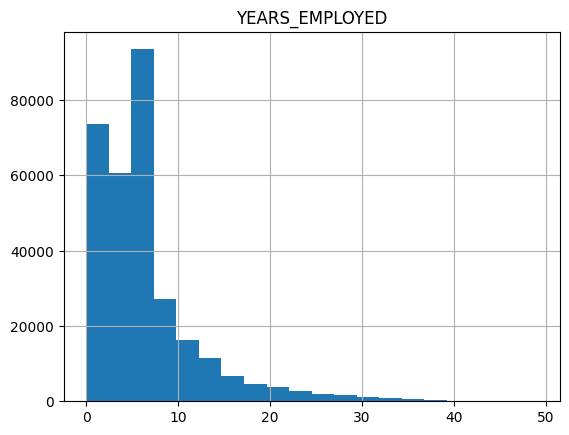

In [36]:
pd.DataFrame.hist(df_application_train, 'YEARS_EMPLOYED', bins=20)

array([[<Axes: title={'center': 'TOTALAREA_MODE'}>]], dtype=object)

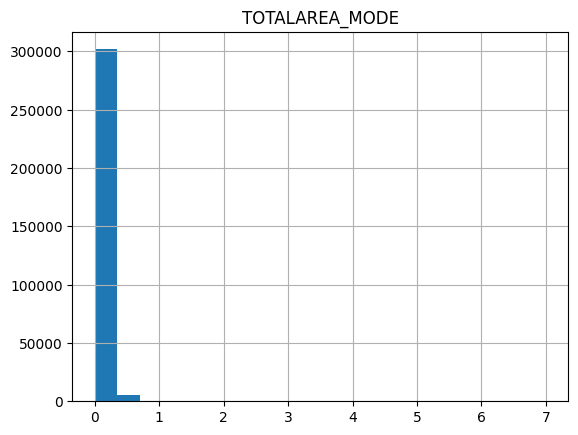

In [37]:
pd.DataFrame.hist(df_application_train, 'TOTALAREA_MODE', bins=20)

### 2.5 Detect Outliers

    After analyzing skewness values and histograms across various columns, it is clear that some columns contain anomalous values.

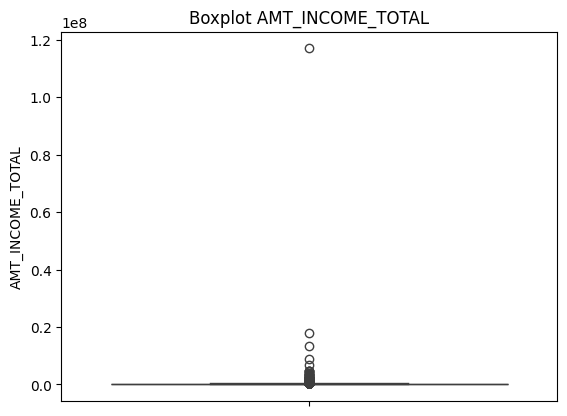

In [38]:
# Create a boxplot 
sns.boxplot(df_application_train['AMT_INCOME_TOTAL'])

# Add labels and title
plt.ylabel('AMT_INCOME_TOTAL')
plt.title('Boxplot AMT_INCOME_TOTAL')

# Show the plot
plt.show()

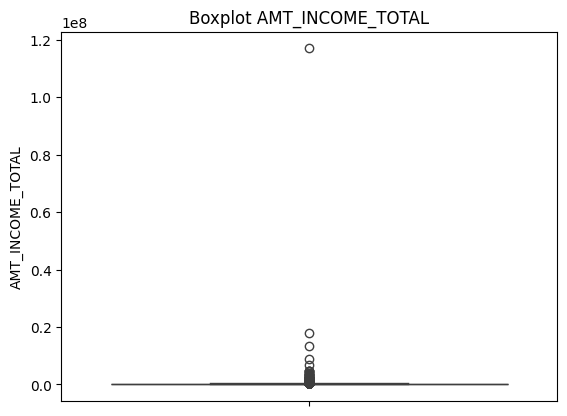

In [39]:
# Create a boxplot 
sns.boxplot(df_application_train['AMT_INCOME_TOTAL'])

# Add labels and title
plt.ylabel('AMT_INCOME_TOTAL')
plt.title('Boxplot AMT_INCOME_TOTAL')

# Show the plot
plt.show()

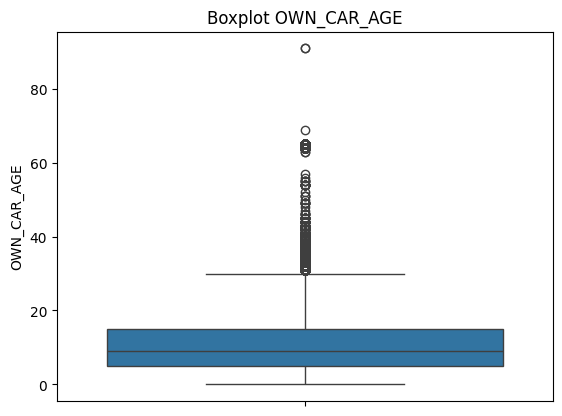

In [40]:
# Create a boxplot 
sns.boxplot(df_application_train['OWN_CAR_AGE'])

# Add labels and title
plt.ylabel('OWN_CAR_AGE')
plt.title('Boxplot OWN_CAR_AGE')

# Show the plot
plt.show()

In [41]:
repeat_percentage(df_application_train, 'OWN_CAR_AGE')

OWN_CAR_AGE
7.0     2.415880
6.0     2.075400
3.0     2.071498
8.0     1.914103
2.0     1.903046
          ...   
69.0    0.000325
50.0    0.000325
47.0    0.000325
48.0    0.000325
52.0    0.000325
Name: count, Length: 62, dtype: float64

In [42]:
np.nanstd(df_application_train.OWN_CAR_AGE.values.tolist())

11.944627462232402

In [43]:
np.nanmean(df_application_train.OWN_CAR_AGE.values)

12.060878711096237

In [44]:
np.isinf(df_application_train[['OWN_CAR_AGE']]).values.sum()

0

In [45]:
# Compute Z Score
car_age_mean = np.nanmean(df_application_train.OWN_CAR_AGE.values.tolist())
car_age_std = np.nanstd(df_application_train.OWN_CAR_AGE.values.tolist())

print("Mean Credit Score is: ", car_age_mean)
print("Std Credit Score is: ", car_age_std)

Mean Credit Score is:  12.060878711096237
Std Credit Score is:  11.944627462232402


In [46]:
df_application_train['zscore_car_age'] = (df_application_train.OWN_CAR_AGE- car_age_mean ) / car_age_std
df_application_train[["SK_ID_CURR", "OWN_CAR_AGE", "zscore_car_age"]].head()

,SK_ID_CURR,OWN_CAR_AGE,zscore_car_age
0,100002,NaN,NaN
1,100003,NaN,NaN
2,100004,26.0,1.166978
3,100006,NaN,NaN
4,100007,NaN,NaN


In [47]:
# Count the number of outliers above the positive threshold
outliers_count_positive = len(df_application_train[df_application_train['zscore_car_age'] > POSITVE_THRESHOLD])

# Count the number of outliers below the negative threshold
outliers_count_negative = len(df_application_train[df_application_train['zscore_car_age'] < NEGATIVE_THRESHOLD])

# Total number of outliers
total_outliers_count = outliers_count_positive + outliers_count_negative

# Print the count of outliers
print("Number of outliers (above threshold):", outliers_count_positive)
print("Number of outliers (below threshold):", outliers_count_negative)
print("Total number of outliers:", total_outliers_count)

Number of outliers (above threshold): 3369
Number of outliers (below threshold): 0
Total number of outliers: 3369


In [48]:
df_application_train.drop('zscore_car_age', axis=1, inplace=True)

### 2.6 Check for Correlations

    Check for Correlations between features in a tabular form

In [49]:
correlation(df_application_train, ['CNT_FAM_MEMBERS', 'CNT_CHILDREN', 'AMT_GOODS_PRICE','AMT_CREDIT', 'AMT_ANNUITY', 'TARGET'], 'TARGET')

,CNT_FAM_MEMBERS,CNT_CHILDREN,AMT_GOODS_PRICE,AMT_CREDIT,AMT_ANNUITY,TARGET
TARGET,0.009312,0.019189,-0.039625,-0.030371,-0.012817,1.000000
CNT_CHILDREN,0.879158,1.000000,-0.001847,0.002151,0.021384,0.019189
CNT_FAM_MEMBERS,1.000000,0.879158,0.061147,0.063166,0.075547,0.009312
AMT_ANNUITY,0.075547,0.021384,0.774837,0.770126,1.000000,-0.012817
AMT_CREDIT,0.063166,0.002151,0.986736,1.000000,0.770126,-0.030371
AMT_GOODS_PRICE,0.061147,-0.001847,1.000000,0.986736,0.774837,-0.039625


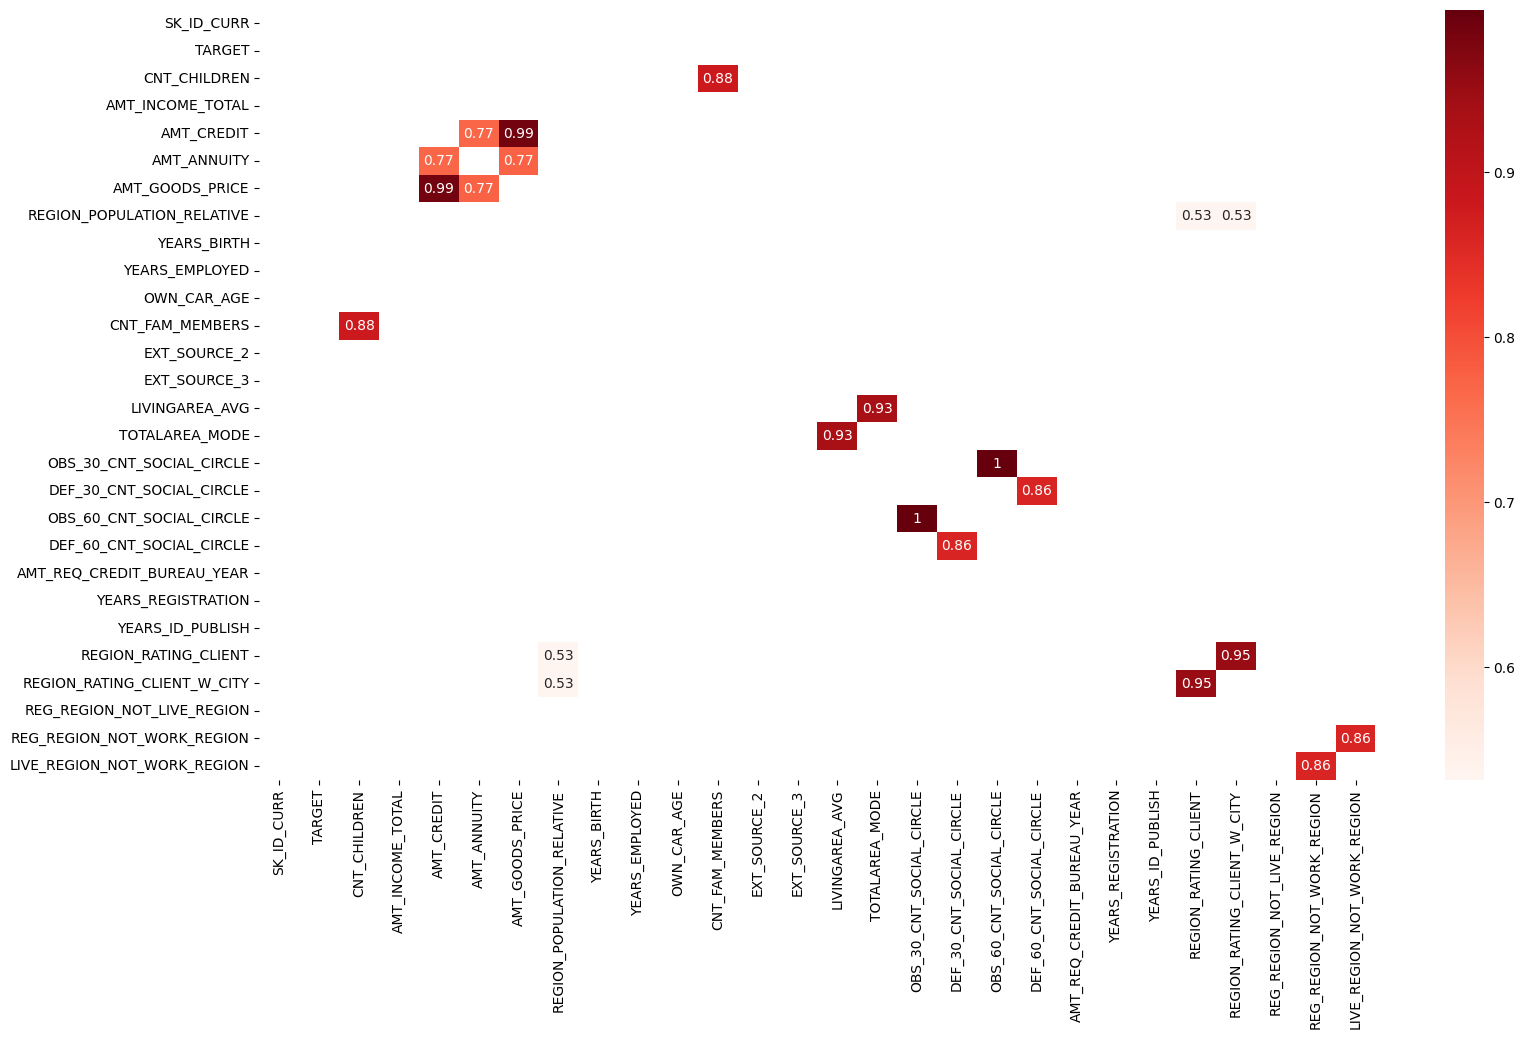

In [50]:
corr_heatmap(numerical_columns, 0.5)

### 2.7 Evaluate Relations within "TARGET" Column

    Evaluate the relation between values in a specific column with the "TARGET" column

In [51]:
relation(df_application_train,'ORGANIZATION_TYPE', 'Postal')

relation between  Postal  and TARGET
 TARGET
0    0.915624
1    0.084376
Name: proportion, dtype: float64 



In [52]:
relation(df_application_train,'DEF_60_CNT_SOCIAL_CIRCLE', 24)

relation between  24  and TARGET
 TARGET
0    1.0
Name: proportion, dtype: float64 



## 3. Preprocess Data

### 3.1 Fill Remaining Nulls 

In [53]:
df_application_train['OCCUPATION_TYPE'].fillna(value='XNA', inplace=True)

In [54]:
df_application_train['OWN_CAR_AGE'].fillna(value=0, inplace=True)

In [55]:
nulls_percentage(df_application_train)

,Missing_Values,Percentage %
SK_ID_CURR,0,0.0
NAME_CONTRACT_TYPE,0,0.0
YEARS_REGISTRATION,0,0.0
YEARS_ID_PUBLISH,0,0.0
REGION_RATING_CLIENT,0,0.0
REGION_RATING_CLIENT_W_CITY,0,0.0
REG_REGION_NOT_LIVE_REGION,0,0.0
REG_REGION_NOT_WORK_REGION,0,0.0
LIVE_REGION_NOT_WORK_REGION,0,0.0
CODE_GENDER,0,0.0


### 3.2 Feature Engineering 

In [56]:
# df_application_train[(df_application_train['REGION_RATING_CLIENT_W_CITY'] == 2)].mean()

In [57]:
''' Create a new feature by combining two existing features, 
calculating an overall rating for a specific region that includes the city. '''

df_application_train['OVERALL_REGION_RATING'] = df_application_train['REGION_RATING_CLIENT_W_CITY']/df_application_train['REGION_POPULATION_RELATIVE']

In [58]:
df_application_train['LOAN_REPAYMENT_PERIOD'] = df_application_train['AMT_CREDIT'] / df_application_train['AMT_ANNUITY']

#### Check the correlation heatmap after feature engineering.

In [59]:
# corr_heatmap(df, 0.4)

### 3.3 Drop Columns

    Dropping columns having high correlation with other columns based on their correlation with the 'TARGET' column to reduce multicollinearity effect. Some unnecessary columns were also removed

In [60]:
df_application_train = df_application_train.drop(['CNT_FAM_MEMBERS', 'AMT_CREDIT',
                                                'LIVINGAREA_AVG', 'OBS_30_CNT_SOCIAL_CIRCLE',
                                                'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
                                                'REGION_RATING_CLIENT','LIVE_REGION_NOT_WORK_REGION','NAME_TYPE_SUITE',
                                                'REG_REGION_NOT_LIVE_REGION', 'YEARS_REGISTRATION', 'YEARS_ID_PUBLISH', 'REG_REGION_NOT_WORK_REGION'], axis=1)

In [61]:
df_application_train.shape

(307507, 27)

### 3.4 Handling Outliers

In [62]:
# Drop the row having an anomaly 'AMT_INCOME_TOTAL' 
df_application_train.drop(df_application_train[df_application_train.AMT_INCOME_TOTAL > 100000000].index, inplace=True)

In [63]:
(df_application_train[['AMT_INCOME_TOTAL']][(df_application_train["AMT_INCOME_TOTAL"] > 10000000)])


,AMT_INCOME_TOTAL
203689,18000090.0
246854,13500000.0


### 3.5 Aggregate Secondary Tables

#### 3.5.1 Bureau Table

In [64]:
explore(df_bureau)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB
None 

Shape: (1716428, 17)


In [65]:
total_loans = df_bureau.groupby('SK_ID_CURR')['SK_ID_BUREAU'].count().reset_index()
total_loans.rename(columns={'SK_ID_BUREAU': 'TOTAL_LOANS'}, inplace=True)

In [66]:
explore(total_loans)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305811 entries, 0 to 305810
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   SK_ID_CURR   305811 non-null  int64
 1   TOTAL_LOANS  305811 non-null  int64
dtypes: int64(2)
memory usage: 4.7 MB
None 

Shape: (305811, 2)


In [67]:
average_delay = df_bureau.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].mean().reset_index()
average_delay.rename(columns={'CREDIT_DAY_OVERDUE': 'AVG_REPAYMENT_DELAY'}, inplace=True)

In [68]:
explore(average_delay)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305811 entries, 0 to 305810
Data columns (total 2 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   SK_ID_CURR           305811 non-null  int64  
 1   AVG_REPAYMENT_DELAY  305811 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 4.7 MB
None 

Shape: (305811, 2)


#### 3.5.2 Previous_Application Table

In [69]:
count_previous_loans = df_previous_application.groupby('SK_ID_CURR')['SK_ID_PREV'].count().reset_index()
count_previous_loans.rename(columns={'SK_ID_PREV': 'COUNT_PREVIOUS_LOANS'}, inplace=True)

In [70]:
count_previous_loans.tail()

,SK_ID_CURR,COUNT_PREVIOUS_LOANS
338852,456251,1
338853,456252,1
338854,456253,2
338855,456254,2
338856,456255,8


In [71]:
explore(count_previous_loans)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338857 entries, 0 to 338856
Data columns (total 2 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   SK_ID_CURR            338857 non-null  int64
 1   COUNT_PREVIOUS_LOANS  338857 non-null  int64
dtypes: int64(2)
memory usage: 5.2 MB
None 

Shape: (338857, 2)


In [72]:
average_loan_amount = df_previous_application.groupby('SK_ID_CURR')['AMT_APPLICATION'].mean().reset_index()
average_loan_amount.rename(columns={'AMT_APPLICATION': 'AVG_LOAN_AMOUNT'}, inplace=True)

In [73]:
average_loan_amount.head()

,SK_ID_CURR,AVG_LOAN_AMOUNT
0,100001,24835.50
1,100002,179055.00
2,100003,435436.50
3,100004,24282.00
4,100005,22308.75


In [74]:
explore(average_loan_amount)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338857 entries, 0 to 338856
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   SK_ID_CURR       338857 non-null  int64  
 1   AVG_LOAN_AMOUNT  338857 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 5.2 MB
None 

Shape: (338857, 2)


#### 3.5.3 Merging Tables

In [75]:
# Merging total loans
df_application_train = df_application_train.merge(total_loans, on='SK_ID_CURR', how='left')

# Merging average repayment delay
df_application_train = df_application_train.merge(average_delay, on='SK_ID_CURR', how='left')

In [76]:
# Merging count of previous loans
df_application_train = df_application_train.merge(count_previous_loans, on='SK_ID_CURR', how='left')

# Merging average loan amount
df_application_train = df_application_train.merge(average_loan_amount, on='SK_ID_CURR', how='left')

In [77]:
df_application_train.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,YEARS_BIRTH,YEARS_EMPLOYED,OWN_CAR_AGE,EXT_SOURCE_2,EXT_SOURCE_3,TOTALAREA_MODE,DEF_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_YEAR,REGION_RATING_CLIENT_W_CITY,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,OVERALL_REGION_RATING,LOAN_REPAYMENT_PERIOD,TOTAL_LOANS,AVG_REPAYMENT_DELAY,COUNT_PREVIOUS_LOANS,AVG_LOAN_AMOUNT
0,100002,1,0,202500.0,24700.5,351000.0,0.018801,25.920548,1.745205,0.0,0.262949,0.139376,0.014900,2,1,2,Cash loans,M,N,Y,Working,Single / not married,House / apartment,Laborers,Business Entity Type 3,106.377320,16.461104,8.0,0.0,1.0,179055.00
1,100003,0,0,270000.0,35698.5,1129500.0,0.003541,45.931507,3.254795,0.0,0.622246,0.380545,0.071400,0,0,1,Cash loans,F,N,N,State servant,Married,House / apartment,Core staff,School,282.406100,36.234085,4.0,0.0,3.0,435436.50
2,100004,0,0,67500.0,6750.0,135000.0,0.010032,52.180822,0.616438,26.0,0.555912,0.729567,0.068559,0,0,2,Revolving loans,M,Y,Y,Working,Single / not married,House / apartment,Laborers,Government,199.362041,20.000000,2.0,0.0,1.0,24282.00
3,100006,0,0,135000.0,29686.5,297000.0,0.008019,52.068493,8.326027,0.0,0.650442,0.451486,0.068800,0,1,2,Cash loans,F,N,Y,Working,Civil marriage,House / apartment,Laborers,Business Entity Type 3,249.407657,10.532818,NaN,NaN,9.0,272203.26
4,100007,0,0,121500.0,21865.5,513000.0,0.028663,54.608219,8.323288,0.0,0.322738,0.451486,0.068800,0,0,2,Cash loans,M,N,Y,Working,Single / not married,House / apartment,Core staff,Religion,69.776367,23.461618,1.0,0.0,6.0,150530.25


In [78]:
df_application_train.isna().sum()

SK_ID_CURR                         0
TARGET                             0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_ANNUITY                        0
AMT_GOODS_PRICE                    0
REGION_POPULATION_RELATIVE         0
YEARS_BIRTH                        0
YEARS_EMPLOYED                     0
OWN_CAR_AGE                        0
EXT_SOURCE_2                       0
EXT_SOURCE_3                       0
TOTALAREA_MODE                     0
DEF_60_CNT_SOCIAL_CIRCLE           0
AMT_REQ_CREDIT_BUREAU_YEAR         0
REGION_RATING_CLIENT_W_CITY        0
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
NAME_INCOME_TYPE                   0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
OCCUPATION_TYPE                    0
ORGANIZATION_TYPE                  0
OVERALL_REGION_RATING              0
LOAN_REPAYMENT_PERIOD              0
T

#### 3.5.4 Cleaning After Merging

In [79]:
# Filling missing values (if no loans exist for a customer)
df_application_train['TOTAL_LOANS'].fillna(0, inplace=True)
df_application_train['AVG_REPAYMENT_DELAY'].fillna(0, inplace=True)

In [80]:
# Filling missing values (if no previous loans exist for a customer)
df_application_train['COUNT_PREVIOUS_LOANS'].fillna(0, inplace=True)
df_application_train['AVG_LOAN_AMOUNT'].fillna(0, inplace=True)

In [81]:
df_application_train.isna().sum()

SK_ID_CURR                     0
TARGET                         0
CNT_CHILDREN                   0
AMT_INCOME_TOTAL               0
AMT_ANNUITY                    0
AMT_GOODS_PRICE                0
REGION_POPULATION_RELATIVE     0
YEARS_BIRTH                    0
YEARS_EMPLOYED                 0
OWN_CAR_AGE                    0
EXT_SOURCE_2                   0
EXT_SOURCE_3                   0
TOTALAREA_MODE                 0
DEF_60_CNT_SOCIAL_CIRCLE       0
AMT_REQ_CREDIT_BUREAU_YEAR     0
REGION_RATING_CLIENT_W_CITY    0
NAME_CONTRACT_TYPE             0
CODE_GENDER                    0
FLAG_OWN_CAR                   0
FLAG_OWN_REALTY                0
NAME_INCOME_TYPE               0
NAME_FAMILY_STATUS             0
NAME_HOUSING_TYPE              0
OCCUPATION_TYPE                0
ORGANIZATION_TYPE              0
OVERALL_REGION_RATING          0
LOAN_REPAYMENT_PERIOD          0
TOTAL_LOANS                    0
AVG_REPAYMENT_DELAY            0
COUNT_PREVIOUS_LOANS           0
AVG_LOAN_A

In [82]:
explore(df_application_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307506 entries, 0 to 307505
Data columns (total 31 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307506 non-null  int64  
 1   TARGET                       307506 non-null  int64  
 2   CNT_CHILDREN                 307506 non-null  int64  
 3   AMT_INCOME_TOTAL             307506 non-null  float64
 4   AMT_ANNUITY                  307506 non-null  float64
 5   AMT_GOODS_PRICE              307506 non-null  float64
 6   REGION_POPULATION_RELATIVE   307506 non-null  float64
 7   YEARS_BIRTH                  307506 non-null  float64
 8   YEARS_EMPLOYED               307506 non-null  float64
 9   OWN_CAR_AGE                  307506 non-null  float64
 10  EXT_SOURCE_2                 307506 non-null  float64
 11  EXT_SOURCE_3                 307506 non-null  float64
 12  TOTALAREA_MODE               307506 non-null  float64
 13 

### 3.6 Normalize Data

    Utilize a robust scaler since the data contains significant outliers that should not be clipped.

In [83]:
numerical = df_application_train.select_dtypes(['int64','float64'])
categorical = df_application_train.select_dtypes('object')

In [84]:
numerical_columns = list(numerical.columns)
categorical_columns = list(categorical.columns)
numerical_columns

['SK_ID_CURR',
 'TARGET',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'YEARS_BIRTH',
 'YEARS_EMPLOYED',
 'OWN_CAR_AGE',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'TOTALAREA_MODE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'REGION_RATING_CLIENT_W_CITY',
 'OVERALL_REGION_RATING',
 'LOAN_REPAYMENT_PERIOD',
 'TOTAL_LOANS',
 'AVG_REPAYMENT_DELAY',
 'COUNT_PREVIOUS_LOANS',
 'AVG_LOAN_AMOUNT']

In [85]:
len(numerical_columns)

22

In [86]:
numerical.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,YEARS_BIRTH,YEARS_EMPLOYED,OWN_CAR_AGE,EXT_SOURCE_2,EXT_SOURCE_3,TOTALAREA_MODE,DEF_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_YEAR,REGION_RATING_CLIENT_W_CITY,OVERALL_REGION_RATING,LOAN_REPAYMENT_PERIOD,TOTAL_LOANS,AVG_REPAYMENT_DELAY,COUNT_PREVIOUS_LOANS,AVG_LOAN_AMOUNT
0,100002,1,0,202500.0,24700.5,351000.0,0.018801,25.920548,1.745205,0.0,0.262949,0.139376,0.014900,2,1,2,106.377320,16.461104,8.0,0.0,1.0,179055.00
1,100003,0,0,270000.0,35698.5,1129500.0,0.003541,45.931507,3.254795,0.0,0.622246,0.380545,0.071400,0,0,1,282.406100,36.234085,4.0,0.0,3.0,435436.50
2,100004,0,0,67500.0,6750.0,135000.0,0.010032,52.180822,0.616438,26.0,0.555912,0.729567,0.068559,0,0,2,199.362041,20.000000,2.0,0.0,1.0,24282.00
3,100006,0,0,135000.0,29686.5,297000.0,0.008019,52.068493,8.326027,0.0,0.650442,0.451486,0.068800,0,1,2,249.407657,10.532818,0.0,0.0,9.0,272203.26
4,100007,0,0,121500.0,21865.5,513000.0,0.028663,54.608219,8.323288,0.0,0.322738,0.451486,0.068800,0,0,2,69.776367,23.461618,1.0,0.0,6.0,150530.25


In [87]:
scaler = RobustScaler()
scaled_data = scaler.fit_transform(numerical)

In [88]:
len(scaled_data[0]) == len(numerical_columns)

True

In [89]:
df_scaled = pd.DataFrame(scaled_data, columns= numerical_columns)
df_scaled.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,YEARS_BIRTH,YEARS_EMPLOYED,OWN_CAR_AGE,EXT_SOURCE_2,EXT_SOURCE_3,TOTALAREA_MODE,DEF_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_YEAR,REGION_RATING_CLIENT_W_CITY,OVERALL_REGION_RATING,LOAN_REPAYMENT_PERIOD,TOTAL_LOANS,AVG_REPAYMENT_DELAY,COUNT_PREVIOUS_LOANS,AVG_LOAN_AMOUNT
0,-1.001153,1.0,0.0,0.615,-0.011205,-0.224490,-0.002626,-0.865181,-0.865900,0.0,-1.120416,-1.538211,-8.985319,2.0,0.0,0.0,0.000000,-0.308110,0.666667,0.0,-0.50,0.618981
1,-1.001147,0.0,0.0,1.365,0.597361,1.540816,-0.820550,0.139634,-0.564313,0.0,0.208116,-0.525522,0.433429,0.0,-0.5,-1.0,1.276422,1.413402,0.000000,0.0,0.00,2.622489
2,-1.001142,0.0,0.0,-0.885,-1.004482,-0.714286,-0.472638,0.453432,-1.091407,5.2,-0.037158,0.940050,-0.040147,0.0,-0.5,0.0,0.674252,0.000000,-0.333333,0.0,-0.50,-0.590501
3,-1.001131,0.0,0.0,-0.135,0.264691,-0.346939,-0.580533,0.447792,0.448823,0.0,0.312373,-0.227633,0.000000,0.0,0.0,0.0,1.037143,-0.824249,-0.666667,0.0,1.50,1.346894
4,-1.001125,0.0,0.0,-0.285,-0.168078,0.142857,0.525969,0.575320,0.448276,0.0,-0.899338,-0.227633,0.000000,0.0,-0.5,0.0,-0.265401,0.301382,-0.500000,0.0,0.75,0.396073


### 3.7 Prepare Data

In [90]:
df_scaled.drop(['SK_ID_CURR', 'REGION_RATING_CLIENT_W_CITY'], axis=1, inplace=True)

In [91]:
explore(df_scaled)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307506 entries, 0 to 307505
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   TARGET                      307506 non-null  float64
 1   CNT_CHILDREN                307506 non-null  float64
 2   AMT_INCOME_TOTAL            307506 non-null  float64
 3   AMT_ANNUITY                 307506 non-null  float64
 4   AMT_GOODS_PRICE             307506 non-null  float64
 5   REGION_POPULATION_RELATIVE  307506 non-null  float64
 6   YEARS_BIRTH                 307506 non-null  float64
 7   YEARS_EMPLOYED              307506 non-null  float64
 8   OWN_CAR_AGE                 307506 non-null  float64
 9   EXT_SOURCE_2                307506 non-null  float64
 10  EXT_SOURCE_3                307506 non-null  float64
 11  TOTALAREA_MODE              307506 non-null  float64
 12  DEF_60_CNT_SOCIAL_CIRCLE    307506 non-null  float64
 13  AMT_REQ_CREDIT

In [92]:
explore(categorical)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307506 entries, 0 to 307505
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   NAME_CONTRACT_TYPE  307506 non-null  object
 1   CODE_GENDER         307506 non-null  object
 2   FLAG_OWN_CAR        307506 non-null  object
 3   FLAG_OWN_REALTY     307506 non-null  object
 4   NAME_INCOME_TYPE    307506 non-null  object
 5   NAME_FAMILY_STATUS  307506 non-null  object
 6   NAME_HOUSING_TYPE   307506 non-null  object
 7   OCCUPATION_TYPE     307506 non-null  object
 8   ORGANIZATION_TYPE   307506 non-null  object
dtypes: object(9)
memory usage: 21.1+ MB
None 

Shape: (307506, 9)


In [93]:
df_processed = pd.concat([df_scaled, categorical], axis=1)

In [94]:
explore(df_processed)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307506 entries, 0 to 307505
Data columns (total 29 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   TARGET                      307506 non-null  float64
 1   CNT_CHILDREN                307506 non-null  float64
 2   AMT_INCOME_TOTAL            307506 non-null  float64
 3   AMT_ANNUITY                 307506 non-null  float64
 4   AMT_GOODS_PRICE             307506 non-null  float64
 5   REGION_POPULATION_RELATIVE  307506 non-null  float64
 6   YEARS_BIRTH                 307506 non-null  float64
 7   YEARS_EMPLOYED              307506 non-null  float64
 8   OWN_CAR_AGE                 307506 non-null  float64
 9   EXT_SOURCE_2                307506 non-null  float64
 10  EXT_SOURCE_3                307506 non-null  float64
 11  TOTALAREA_MODE              307506 non-null  float64
 12  DEF_60_CNT_SOCIAL_CIRCLE    307506 non-null  float64
 13  AMT_REQ_CREDIT

In [95]:
df_processed.head()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,YEARS_BIRTH,YEARS_EMPLOYED,OWN_CAR_AGE,EXT_SOURCE_2,EXT_SOURCE_3,TOTALAREA_MODE,DEF_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_YEAR,OVERALL_REGION_RATING,LOAN_REPAYMENT_PERIOD,TOTAL_LOANS,AVG_REPAYMENT_DELAY,COUNT_PREVIOUS_LOANS,AVG_LOAN_AMOUNT,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE
0,1.0,0.0,0.615,-0.011205,-0.224490,-0.002626,-0.865181,-0.865900,0.0,-1.120416,-1.538211,-8.985319,2.0,0.0,0.000000,-0.308110,0.666667,0.0,-0.50,0.618981,Cash loans,M,N,Y,Working,Single / not married,House / apartment,Laborers,Business Entity Type 3
1,0.0,0.0,1.365,0.597361,1.540816,-0.820550,0.139634,-0.564313,0.0,0.208116,-0.525522,0.433429,0.0,-0.5,1.276422,1.413402,0.000000,0.0,0.00,2.622489,Cash loans,F,N,N,State servant,Married,House / apartment,Core staff,School
2,0.0,0.0,-0.885,-1.004482,-0.714286,-0.472638,0.453432,-1.091407,5.2,-0.037158,0.940050,-0.040147,0.0,-0.5,0.674252,0.000000,-0.333333,0.0,-0.50,-0.590501,Revolving loans,M,Y,Y,Working,Single / not married,House / apartment,Laborers,Government
3,0.0,0.0,-0.135,0.264691,-0.346939,-0.580533,0.447792,0.448823,0.0,0.312373,-0.227633,0.000000,0.0,0.0,1.037143,-0.824249,-0.666667,0.0,1.50,1.346894,Cash loans,F,N,Y,Working,Civil marriage,House / apartment,Laborers,Business Entity Type 3
4,0.0,0.0,-0.285,-0.168078,0.142857,0.525969,0.575320,0.448276,0.0,-0.899338,-0.227633,0.000000,0.0,-0.5,-0.265401,0.301382,-0.500000,0.0,0.75,0.396073,Cash loans,M,N,Y,Working,Single / not married,House / apartment,Core staff,Religion


## 4. Save Data

    Save a checkpoint for the processed data 

In [96]:
df_processed.to_csv(f'{PROCESSED_DIR}\df_processed_v0.2.csv')

## 5. Train Model

### 5.1 Split Data

    Split the data into train and test data

In [97]:
y = df_processed['TARGET']
X = df_processed.drop(['TARGET'], axis=1)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=42, stratify=y)
print("X_train = ",X_train.shape ," y_train = ", y_train.shape)
print("X_test  = ",X_test.shape ," y_test  = ", y_test.shape)

X_train =  (230629, 28)  y_train =  (230629,)
X_test  =  (76877, 28)  y_test  =  (76877,)


In [99]:
categorical_columns

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_INCOME_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE']

### 5.2 Train Model

In [100]:
# model = CatBoostClassifier( learning_rate=0.05, iterations=1100, cat_features=categorical_columns, auto_class_weights='Balanced', eval_metric='AUC', task_type="GPU",  verbose=100)
# model.fit(X_train, y_train, eval_set=(X_test, y_test))

In [101]:
# Tuned the depth and the number of iterations 
model_2 = CatBoostClassifier(learning_rate=0.0515, iterations=700, cat_features=categorical_columns, auto_class_weights='Balanced', depth=5, random_seed=42, eval_metric='AUC', task_type="GPU", verbose=100)
model_2.fit(X_train, y_train, eval_set=(X_test, y_test))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7049340	best: 0.7049340 (0)	total: 121ms	remaining: 1m 24s
100:	test: 0.7509167	best: 0.7509167 (100)	total: 10.4s	remaining: 1m 1s
200:	test: 0.7571812	best: 0.7571812 (200)	total: 20.6s	remaining: 51.1s
300:	test: 0.7597075	best: 0.7597075 (300)	total: 31s	remaining: 41.1s
400:	test: 0.7610704	best: 0.7610704 (400)	total: 41.2s	remaining: 30.7s
500:	test: 0.7620431	best: 0.7620431 (500)	total: 52.2s	remaining: 20.7s
600:	test: 0.7625263	best: 0.7625263 (600)	total: 1m 4s	remaining: 10.6s
699:	test: 0.7631628	best: 0.7631628 (699)	total: 1m 16s	remaining: 0us
bestTest = 0.7631627917
bestIteration = 699


In [102]:
# param_grid = {
#     'iterations': [ 1500,  950, 630, 400 ],
#     'learning_rate': [0.01, 0.03, 0.05, 0.075],
# }

# # Perform the grid search
# grid_search_result = model.grid_search(param_grid, X=X_train, y=y_train, cv=3, verbose=1)

# # Print the best parameters
# print("Best Parameters:", grid_search_result['params'])

In [103]:
# # Tuning some hyperparameters and observing their effect
# model1 = CatBoostClassifier( iterations=1250, learning_rate=0.031, cat_features=cat_columns,auto_class_weights='Balanced',eval_metric="AUC", task_type="GPU", verbose=100)
# model1.fit(X_train, y_train, eval_set=(X_test, y_test))

### 5.3 Evaluation

In [108]:
# # Evaluating the first model (model)  
# y_pred_1 = model.predict(X_test)
# print("CatBoost Model Evaluation Metrics:")
# print(classification_report(y_test, y_pred_1))
# print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))

In [105]:
# Evaluating model_2 which is trained after tuning hyperparameters 
y_pred_2 = model_2.predict(X_test)
print("CatBoost Model Evaluation Metrics:")
print(classification_report(y_test, y_pred_2))
print("ROC AUC Score:", roc_auc_score(y_test, model_2.predict_proba(X_test)[:, 1]))

CatBoost Model Evaluation Metrics:
              precision    recall  f1-score   support

         0.0       0.96      0.71      0.82     70671
         1.0       0.17      0.68      0.27      6206

    accuracy                           0.71     76877
   macro avg       0.57      0.70      0.55     76877
weighted avg       0.90      0.71      0.77     76877

ROC AUC Score: 0.7631627636329994


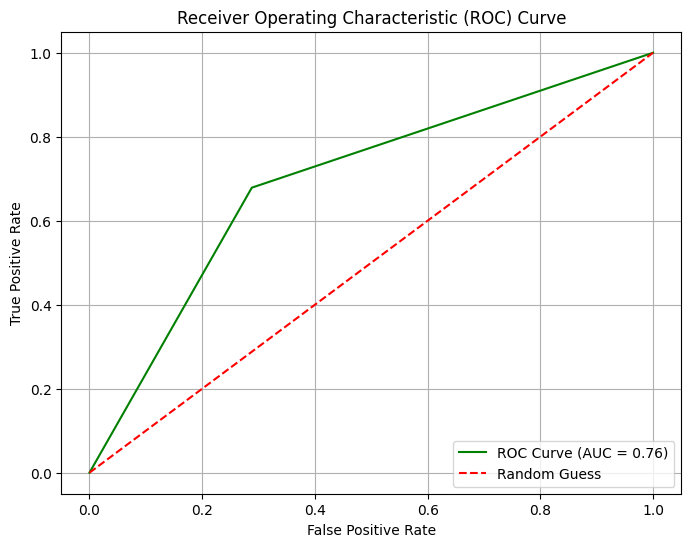

In [106]:
model_2_AUC= roc_auc_score(y_test, model_2.predict_proba(X_test)[:, 1])
fpr, tpr, thresholds = roc_curve(y_test, y_pred_2)

# Plot the ROC curve for model_2
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {model_2_AUC:.2f})', color='green')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')  # Dashed diagonal for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

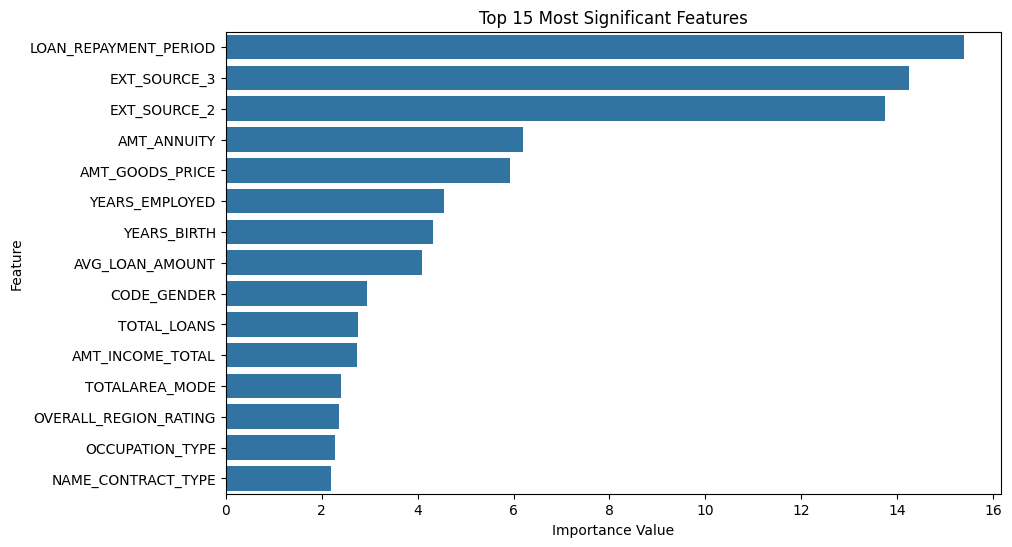

In [119]:
# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model_2.get_feature_importance()
})

# Sort by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Visualize the top 10 most significant features
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance.head(15)  # Select top 10 features
)
plt.title('Top 15 Most Significant Features')
plt.xlabel('Importance Value')
plt.ylabel('Feature')
plt.show()


### 5.4 Save Model

    Save the best-trained model for deployment purposes.

In [107]:
model_2.save_model(f'{MODEL_DIR}\catboost_model.cbm')